In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from collections import Counter
from sklearn.preprocessing import StandardScaler

In [4]:
def ecdf(x):      #эмпирическая функция распределения
    x = np.sort(x)
    n = x.size
    y = np.arange(1, n+1) / n
    return x, y

def mode_value(x): # ищем самые часто встречающиеся элементы
    cnt = Counter(x)
    max_count = max(cnt.values())
    modes = [val for val, c in cnt.items() if c == max_count]

    return modes, max_count

In [5]:
def chi_square_test_manual(sample, bins='sturges'): 
    n = sample.size
    if isinstance(bins, str):
        if bins == 'sturges':
            k = int(np.ceil(np.log2(n) + 1))
        elif bins == 'sqrt':
            k = int(np.ceil(np.sqrt(n)))
        else:
            k = 10
    else:
        k = int(bins)

    probs = np.linspace(0, 1, k+1)  # делим на интервалы
    edges = np.quantile(sample, probs)
    edges[0] = -np.inf
    edges[-1] = np.inf

    observed_counts, _ = np.histogram(sample, bins=edges)

    mu = np.mean(sample)
    sigma = np.std(sample, ddof=0)

    expected_probs = []
    for i in range(len(edges)-1):
        cdf_high = stats.norm.cdf(edges[i+1], loc=mu, scale=sigma)
        cdf_low = stats.norm.cdf(edges[i], loc=mu, scale=sigma)
        expected_probs.append(cdf_high - cdf_low)

    expected_probs = np.array(expected_probs)
    expected_counts = expected_probs * n

    obs = observed_counts.copy().astype(float)
    exp = expected_counts.copy().astype(float)

    # Объединение интервалов с малым ожиданием,<5
    i = 0
    while i < len(exp):
        if exp[i] < 5:
            if i == 0:
                exp[i+1] += exp[i]; obs[i+1] += obs[i]
            else:
                exp[i-1] += exp[i]; obs[i-1] += obs[i]
            exp = np.delete(exp, i)
            obs = np.delete(obs, i)
            i = 0
        else:
            i += 1

    chi2_stat = ((obs - exp)**2 / exp).sum()
    df = exp.size - 1 - 2  
    p_value = 1 - stats.chi2.cdf(chi2_stat, df)

    return {
        'chi2_stat': chi2_stat,
        'df': df,
        'p_value': p_value,
        'observed': observed_counts,
        'expected': expected_counts,
        'edges': edges
    }


In [6]:
def describe_stats(x): # Считает основные характеристики распределения (mean, var,mode, median, quantiles,skew, kurtosis) + тест на нормальность
    x = np.asarray(x)
    n = x.size
    mean = x.mean()
    var = x.var(ddof=1)
    med = np.median(x)
    q25, q50, q75 = np.quantile(x, [0.25, 0.5, 0.75])
    modes, mode_count = mode_value(x.round(6)) # округлеям для устойчивости
    skew = stats.skew(x, bias=False)
    kurt = stats.kurtosis(x, fisher=True, bias=False)
    iqr = q75 - q25
    
    # Тесты по асимметрии и эксцессу (z-статистика)
    se_skew = np.sqrt(6.0 / n)
    z_skew = skew / se_skew
    p_skew = 2 * (1 - stats.norm.cdf(abs(z_skew)))
    
    se_kurt = np.sqrt(24.0 / n)
    z_kurt = kurt / se_kurt
    p_kurt = 2 * (1 - stats.norm.cdf(abs(z_kurt)))
    
    return {
    'n': n,
    'mean': mean,
    'var': var,
    'mode': (modes, mode_count),
    'median': med,
    'quantiles': (q25, q50, q75),
    'excess_kurtosis': kurt,
    'skewness': skew,
    'iqr': iqr,
    'z_skew': z_skew,
    'p_skew': p_skew,
    'z_kurt': z_kurt,
    'p_kurt': p_kurt
    }

In [7]:
df = pd.read_csv('teen_phone_addiction_dataset.csv')

N = 8 # мой список в группее
cols = ['Daily_Usage_Hours', 'Sleep_Hours', 'Exercise_Hours', 'Screen_Time_Before_Bed', 'Time_on_Social_Media', 'Time_on_Gaming', 'Time_on_Education']
selected_col = cols[N % 7]

series = df[selected_col].dropna().astype(float)


 Первый пункт
n: 3000
mean: 6.489766666666668
var: 2.2222260208958544
mode: ([np.float64(6.1)], 89)
median: 6.5
quantiles: (np.float64(5.5), np.float64(6.5), np.float64(7.5))
excess_kurtosis: -0.2954414857948535
skewness: 0.011854250604519176
iqr: 2.0
z_skew: 0.2650691017402285
p_skew: 0.7909562294323667
z_kurt: -3.303136228054155
p_kurt: 0.0009560992839912075


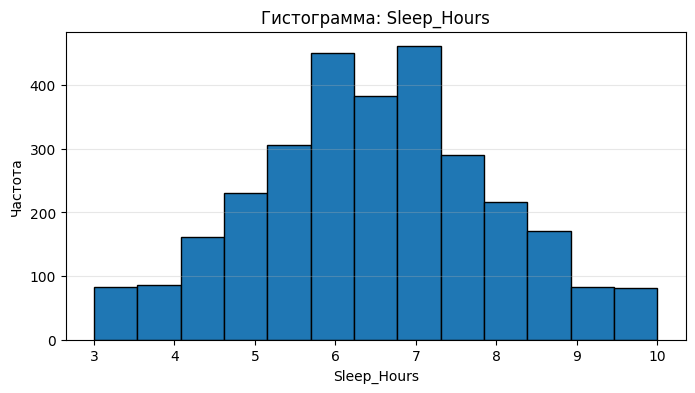

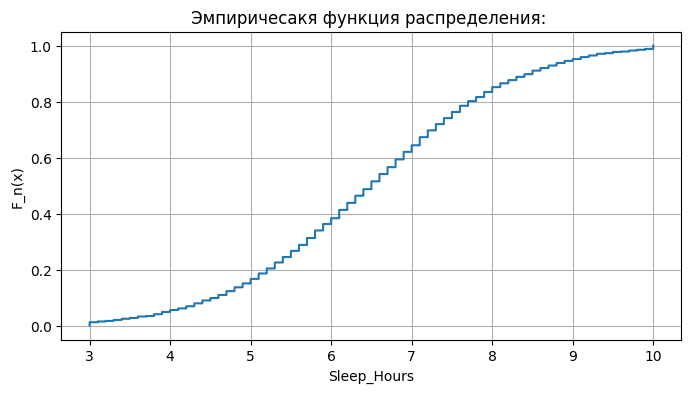


1) Описание числовых характеристик и графиков для исходных данных:
- Объём выборки: 3000
- Среднее: 6.4898, Медиана: 6.5000, Мода(ы): [np.float64(6.1)]
- Дисперсия: 2.2222, IQR: 2.0000
- Асимметрия: 0.0119 (z=0.27, p=0.7910)
- Эксцесс: -0.2954 (z=-3.30, p=0.0010)


In [12]:
print('\n Первый пункт')
st = describe_stats(series.values)
for k, v in st.items():
    print(f'{k}: {v}')

# Гистограмма
plt.figure(figsize=(8,4))
plt.hist(series, bins='sturges', edgecolor='black')
plt.title(f'Гистограмма: {selected_col}')
plt.xlabel(selected_col)
plt.ylabel('Частота')
plt.grid(axis='y', alpha=0.3)
plt.show()

# Эмпирическая функция распределения
x_ecdf, y_ecdf = ecdf(series.values)
plt.figure(figsize=(8,4))
plt.step(x_ecdf, y_ecdf, where='post')
plt.title('Эмпиричесакя функция распределения: ')
plt.xlabel(selected_col)
plt.ylabel('F_n(x)')
plt.grid()
plt.show()

print(f"- Объём выборки: {st['n']}")
print(f"- Среднее: {st['mean']:.4f}, Медиана: {st['median']:.4f}, Мода(ы): {st['mode'][0]}")
print(f"- Дисперсия: {st['var']:.4f}, IQR: {st['iqr']:.4f}")
print(f"- Асимметрия: {st['skewness']:.4f} (z={st['z_skew']:.2f}, p={st['p_skew']:.4f})")
print(f"- Эксцесс: {st['excess_kurtosis']:.4f} (z={st['z_kurt']:.2f}, p={st['p_kurt']:.4f})")


 Второй пункт
Chi2 stat: 9.135350738595232
df: 10
p-value: 0.5193083610873546
z_skew, p_skew: 0.2650691017402285 0.7909562294323667
z_kurt, p_kurt: -3.303136228054155 0.0009560992839912075


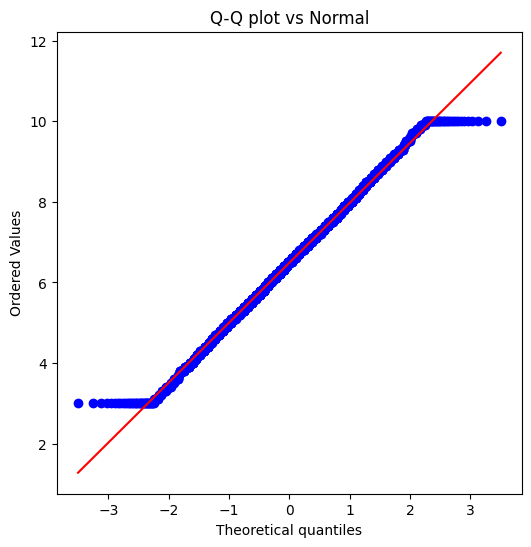


Являются ли данные нормальными?
Данные не являются нормальными по эксцессу (z_kurt < 0 && p_kurt << 0.05).


In [15]:
print('\n Второй пункт')

chi = chi_square_test_manual(series.values, bins='sturges')
print('Chi2 stat:', chi['chi2_stat'])
print('df:', chi['df'])
print('p-value:', chi['p_value'])

print('z_skew, p_skew:', st['z_skew'], st['p_skew'])
print('z_kurt, p_kurt:', st['z_kurt'], st['p_kurt'])

plt.figure(figsize=(6,6))
stats.probplot(series.values, dist='norm', plot=plt)
plt.title('Q-Q plot vs Normal')
plt.show()

print('\nЯвляются ли данные нормальными?')
print('Данные не являются нормальными по эксцессу (z_kurt < 0 && p_kurt << 0.05).')


Третий пункт
Размер после удаления выбросов: 3000 из 3000

Статистики для обрезанных данных:
n: 3000
mean: 6.489766666666668
var: 2.2222260208958544
mode: ([np.float64(6.1)], 89)
median: 6.5
quantiles: (np.float64(5.5), np.float64(6.5), np.float64(7.5))
excess_kurtosis: -0.2954414857948535
skewness: 0.011854250604519176
iqr: 2.0
z_skew: 0.2650691017402285
p_skew: 0.7909562294323667
z_kurt: -3.303136228054155
p_kurt: 0.0009560992839912075

Статистики для стандартизованных данных:
n: 3000
mean: -9.106789396658618e-16
var: 1.0003334444814937
mode: ([np.float64(-0.261507)], 89)
median: 0.006865867230216801
quantiles: (np.float64(-0.6640657839311225), np.float64(0.006865867230216801), np.float64(0.6777975183915561))
excess_kurtosis: -0.2954414857948544
skewness: 0.011854250604521865
iqr: 1.3418633023226785
z_skew: 0.26506910174028864
p_skew: 0.7909562294323202
z_kurt: -3.3031362280541647
p_kurt: 0.0009560992839912075

Статистики для log1p(сдвинутых) данных:
n: 3000
mean: 1.9925911107543162

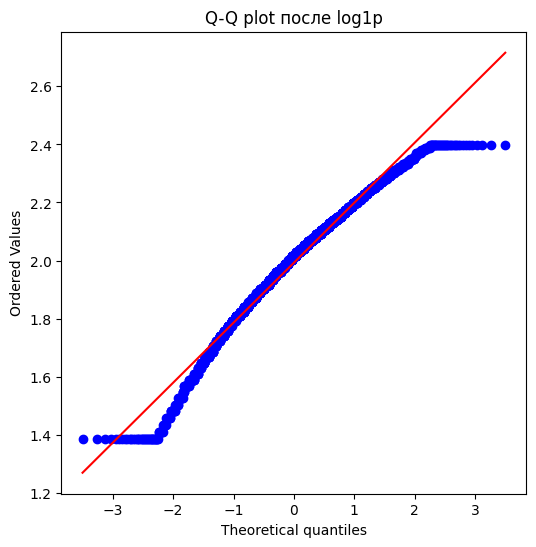

Chi2 stat (log): 80.87815757022784 df: 10 p-value: 3.377298440909726e-13
z_skew (log), p_skew: -12.165411825121183 0.0
z_kurt (log), p_kurt: 2.0804553435296635 0.03748378755454973

Эффект от обработки данных:
После удаления выбросов и лог-преобразования показатели асимметрии и экссеса стали ближе к нулю.


In [16]:
print('\nТретий пункт')

#Удаляю выбросы по правилу IQR
q25, q75 = np.quantile(series.values, [0.25, 0.75])
iqr = q75 - q25
lower = q25 - 1.5 * iqr
upper = q75 + 1.5 * iqr
series_trimmed = series[(series >= lower) & (series <= upper)].copy()
print('Размер после удаления выбросов:', len(series_trimmed), 'из', len(series))

st_trimmed = describe_stats(series_trimmed.values)
print('\nСтатистики для обрезанных данных:')
for k, v in st_trimmed.items():
    print(f'{k}: {v}')

#Стандартизация
scaler = StandardScaler()
series_std = pd.Series(scaler.fit_transform(series_trimmed.values.reshape(-1,1)).flatten())
st_std = describe_stats(series_std.values)
print('\nСтатистики для стандартизованных данных:')
for k, v in st_std.items():
    print(f'{k}: {v}')

min_val = series_trimmed.min()
if min_val <= 0:
    shift = abs(min_val) + 1e-6
else:
    shift = 0.0
series_log = np.log1p(series_trimmed + shift)
st_log = describe_stats(series_log.values)
print('\nСтатистики для log1p(сдвинутых) данных:')
for k, v in st_log.items():
    print(f'{k}: {v}')

plt.figure(figsize=(6,6))
stats.probplot(series_log, dist='norm', plot=plt)
plt.title('Q-Q plot после log1p')
plt.show()


# Chi-square для лог-преобразованных
chi_log = chi_square_test_manual(series_log, bins='sturges')
print('Chi2 stat (log):', chi_log['chi2_stat'], 'df:', chi_log['df'], 'p-value:', chi_log['p_value'])
print('z_skew (log), p_skew:', st_log['z_skew'], st_log['p_skew'])
print('z_kurt (log), p_kurt:', st_log['z_kurt'], st_log['p_kurt'])

print('\nЭффект от обработки данных:')
print('После удаления выбросов и лог-преобразования показатели асимметрии и экссеса стали ближе к нулю.')

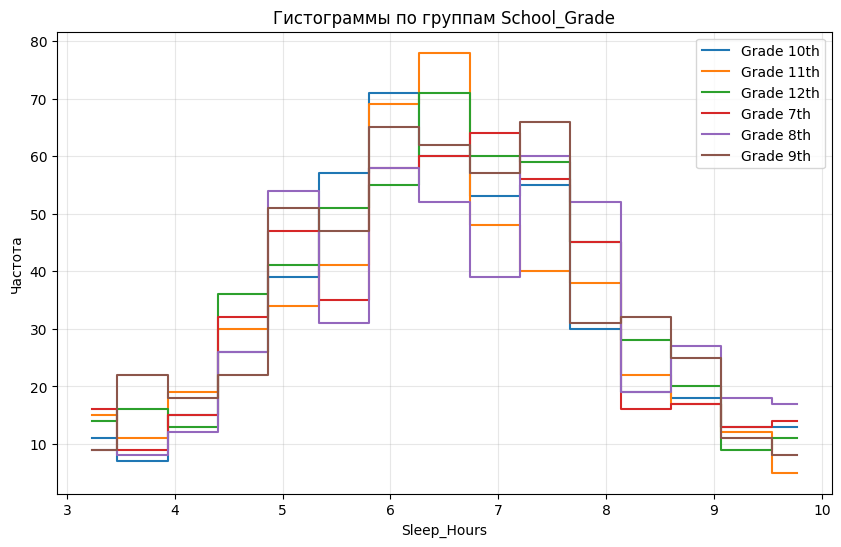

In [29]:
print('\Четверытй пункт')

grades = df['School_Grade'].unique()
plt.figure(figsize=(10,6))
max_edges = None
for g in sorted(grades):
    subset = df[df['School_Grade'] == g][selected_col].dropna().astype(float)
    counts, edges = np.histogram(subset, bins=15)
    centers = 0.5 * (edges[:-1] + edges[1:])
    plt.step(centers, counts, where='mid', label=f'Grade {g}')
    
plt.title('School_Grade')
plt.xlabel(selected_col)
plt.ylabel('Частота')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

print('\nРазличия внутри School_Grade:')
print('В распределениях наблюдаме систематический сдвиг в сторону уменьшения продолжительности сна с увеличением номера класса')